# Deep Learning

## Imports

In [1]:
# just to make sure that all libraries are available
%pip install tensorflow matplotlib pandas folium kaggle scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import math
import string

## Get data from Kaggle

In [4]:
os.environ['KAGGLE_USERNAME'] = "x"
os.environ['KAGGLE_KEY'] = "x"

In [5]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

401 - Unauthorized


In [6]:
!mkdir yelp-data
!unzip -d yelp-data yelp-dataset.zip

mkdir: yelp-data: File exists
Archive:  yelp-dataset.zip
replace yelp-data/Dataset_User_Agreement.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Examine and plot it

In [3]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
target_file = "yelp_academic_dataset_review.json"

In [4]:
data_file = data_dir + target_file

In [5]:
def read_to_dataframe(data_file, max_nl = 100_000):
  data = []
  with open(data_file) as f:
    nl = 0
  
    for line in f:
      data.append(json.loads(line))
    
      nl += 1
      if nl >= max_nl:
        break

  return pd.DataFrame(data)

In [6]:
data_df = read_to_dataframe(data_file)

In [7]:
data_df.head() # to get an idea as to what we're dealing with

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
data_df.info() # all entries are non-null! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   useful       100000 non-null  int64  
 5   funny        100000 non-null  int64  
 6   cool         100000 non-null  int64  
 7   text         100000 non-null  object 
 8   date         100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


In [13]:
data_df.describe()

,stars,useful,funny,cool
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.842910,0.898980,0.257180,0.347030
std,1.354729,2.205186,1.010212,1.066382
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,320.000000,98.000000,49.000000


I don't particularly like the identifiers used in this dataframe, so I'll join this data with the data containing additional information about them so that we get much more meaningful and human-friendly data.

In [7]:
business_file = "yelp_academic_dataset_business.json"

business_df = read_to_dataframe(data_dir + business_file, max_nl=math.inf) # no need to set a limit (the file is 113MB large)
business_df.drop(["stars"], axis=1, inplace=True) # this is the rating of the businesses (we don't care about that)

In [51]:
rich_data = pd.merge(data_df, business_df, on="business_id")

In [52]:
rich_data.head() # as we can see, we now have a richer dataset, which makes it easier to identify the businesses (as far as the reviews and the users are concerned, it's not important to further enrich the data)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,VJxlBnJmCDIy8DFG0kjSow,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
2,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
4,M0wzFFb7pefOPcxeRVbLag,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."


For a much cooler visualization, we can use the folium library!

In [ ]:
import folium

fol_fig = folium.Figure(width=1000, height=600)

# Create a map object centered at a specific location (e.g., the geographical center of North America (we know the data is from USA and Canada))
map_obj = folium.Map(location=[39.7392, -104.9903], zoom_start=4, tiles='Stamen Toner').add_to(fol_fig)

sampled_df = rich_data.sample(n=1000) # to speed up execution (up to 1000 works fine, above that it starts to slow down significantly)
# Iterate over your dataset and add markers for each data point
for index, row in sampled_df.iterrows():
    # Extract the latitude and longtude values from your dataframe
    latitude = row['latitude']
    longitude = row['longitude']
    
    # Add a marker to the map for each data point
    folium.Marker([latitude, longitude]).add_to(map_obj)

# Display the map
map_obj

## Prepare the data 

### Let's define some useful functions

In [10]:
def prepare_for_model(train_dataset, m, val_dataset, test_dataset, preprocess_fn, batch_size=64):
    # Apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # Shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # Batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared

### And some useful hyperparameters

In [11]:
vocabulary_size = 30_000
random_state = 42 # for reproducibility
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [12]:
# Load your dataset into a pandas DataFrame
# Split the dataset into features (X) and labels (y)
X = rich_data['text']
y = rich_data['stars']

# Split the dataset into training (70%), validation (15%), and testing (15%) sets
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, train_size=train_size, stratify=y, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


In [13]:
# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [14]:
# we have the very convenient TextVectorizatoin layer for preprocessing which takes care of everything from standardization to vectorization!
text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    # the option below is only useful if output_mode is "int" (it takes care of the padding)
    # output_sequence_length=max_length,
)

In [15]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [16]:
train_dataset_prep, val_dataset_prep, test_dataset_prep = prepare_for_model(
    train_dataset, len(X_train), val_dataset, test_dataset, text_vectorization)

Let's take a look at the data!

In [17]:
for inputs, targets in train_dataset_prep:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)

    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

2023-06-11 16:15:59.363306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44136 of 70000
2023-06-11 16:16:05.048983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


inputs.shape: (64, 30000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([0. 1. 1. ... 0. 0. 0.], shape=(30000,), dtype=float32)
targets[0]: tf.Tensor(3.0, shape=(), dtype=float64)


## Find correct architecture

Let's try a simple 1-gram bag-of-words model first:

In [18]:
def create_model(input_dim):
    input = tf.keras.Input(shape=(input_dim,))

    x = layers.Dense(256, activation='relu')(input)  # Dense layer with 32 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(256, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(128, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(64, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(64, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5

    output = layers.Dense(1)(x)  # Output layer with a single neuron (regression)

    model = tf.keras.Model(inputs=input, outputs=output)

    # Compile the model with mean squared error (MSE) loss for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [89]:
model_1gram = create_model(vocabulary_size)

In [90]:
model_1gram.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_30 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0   

In [91]:
from tqdm.keras import TqdmCallback

history_1gram = model_1gram.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep,
    epochs=n_epochs, # adjust this parameter if the training is too slow
    # because of https://stackoverflow.com/questions/41442276/keras-verbose-training-progress-bar-writing-a-new-line-on-each-batch-issue
    verbose=0,
    callbacks=[TqdmCallback(verbose=2)],
)











 20%|██        | 2/10 [42:04<2:48:17, 1262.21s/epoch, loss=0.577, mse=0.577, val_loss=0.543, val_mse=0.543]
  0%|          | 0.00/1.09k [40:51<?, ?batch/s]
 30%|███       | 3/10 [38:40<1:30:15, 773.61s/epoch, loss=0.441, mse=0.441, val_loss=0.526, val_mse=0.526]
  2%|▏         | 20.0/1.09k [36:47<32:55:53, 110s/batch, loss=0.376, mse=0.376]
2023-06-09 19:17:50.142502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41496 of 69997
2023-06-09 19:17:57.192435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.




































































































































































































































































































































































































In [57]:
def plot_training_curves(history):
    # Plot loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

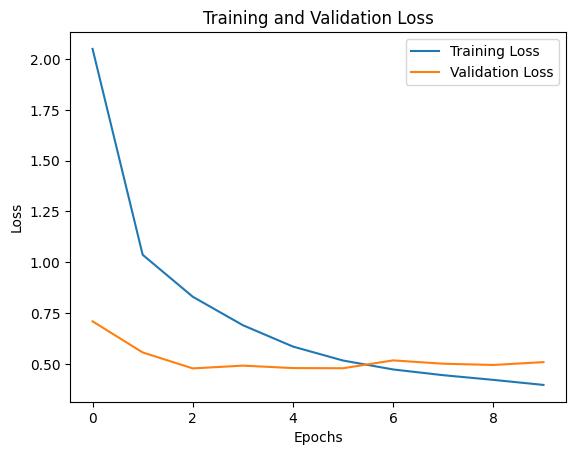

In [93]:
plot_training_curves(history_1gram)

Let's experiment with a 2-gram model!

In [64]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    ngrams=2, # it's that simple!
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    # the option below is only useful if output_mode is "int" (it takes care of the padding)
    # output_sequence_length=max_length,
)

In [66]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [70]:
model_2gram = create_model(vocabulary_size)

In [92]:
model_2gram.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_24 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0   

In [71]:
# we're going to train on the exact same model! (to check whether using 2grams actually makes a difference)
from tqdm.keras import TqdmCallback

history_2gram = model_2gram.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep,
    epochs=n_epochs,
    # because of https://stackoverflow.com/questions/41442276/keras-verbose-training-progress-bar-writing-a-new-line-on-each-batch-issue
    verbose=0,
    callbacks=[TqdmCallback(verbose=2)],
)















2023-06-09 18:57:41.128128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 39448 of 69997
2023-06-09 18:57:48.767068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



























































































































































































































































































































































































































































































































































































































































2023-06-09 18:58:20.558586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Fill

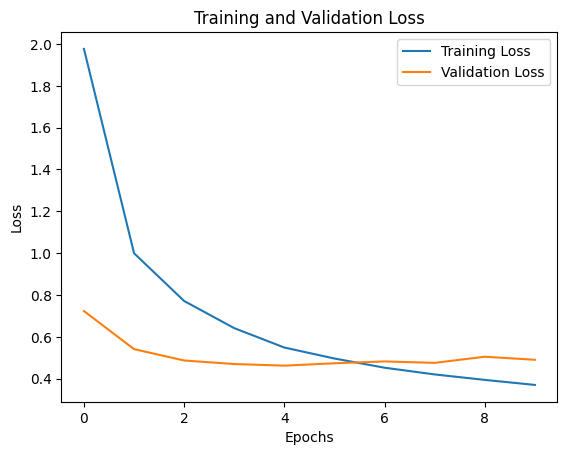

In [84]:
plot_training_curves(history_2gram)

They look quite similar.

In [96]:
# Evaluate model 1
loss_1, mse_1= model_1gram.evaluate(test_dataset_prep)
print(f"Model 1 - Test Loss: {loss_1:.4f}, MSE: {mse_1:.4f}")

# Evaluate model 2
loss_2, mse_2 = model_2gram.evaluate(test_dataset_prep)
print(f"Model 2 - Test Loss: {loss_2:.4f}, MSE: {mse_2:.4f}")


235/235 [==============================] - 5s 20ms/step - loss: 0.5093 - mse: 0.5093
Model 1 - Test Loss: 0.5093, MSE: 0.5093
235/235 [==============================] - 5s 19ms/step - loss: 0.4867 - mse: 0.4867
Model 2 - Test Loss: 0.4867, MSE: 0.4867


The 2-gram model is a bit better at evaluation time. Hurray!

In [19]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=vocabulary_size,
    output_mode='tf_idf', # once again, it's that simple
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)

In [20]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [23]:
model_tfidf = create_model(vocabulary_size)

In [24]:
model_tfidf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 256)               7680256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [27]:
# we're going to train on the exact same model! (to check whether using 2grams actually makes a difference)
from tqdm.keras import TqdmCallback

history_tfidf = model_tfidf.fit(
    train_dataset_prep,
    validation_data=val_dataset_prep,
    epochs=n_epochs,
    # because of https://stackoverflow.com/questions/41442276/keras-verbose-training-progress-bar-writing-a-new-line-on-each-batch-issue
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)],
)







2023-06-11 16:33:50.839756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40467 of 70000
2023-06-11 16:33:58.102559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.































































































































































































































































































































2023-06-11 16:34:31.145198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42002 of 70000
2023-06-11 16:34:37.920676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



























































































































































In [28]:
# Evaluate the TF-IDF model
loss_tfidf, mse_tfidf = model_tfidf.evaluate(test_dataset_prep)
print(f"Model 2 - Test Loss: {loss_tfidf:.4f}, MSE: {mse_tfidf:.4f}")

235/235 [==============================] - 5s 22ms/step - loss: 0.5073 - mse: 0.5073
Model 2 - Test Loss: 0.5073, MSE: 0.5073


It seems that TF-IDF doesn't change much.

## So far we've only used textual data, why don't we use the rest?

## Time for some feature engineering!

In [29]:
rich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   review_id     100000 non-null  object 
 1   user_id       100000 non-null  object 
 2   business_id   100000 non-null  object 
 3   stars         100000 non-null  float64
 4   useful        100000 non-null  int64  
 5   funny         100000 non-null  int64  
 6   cool          100000 non-null  int64  
 7   text          100000 non-null  object 
 8   date          100000 non-null  object 
 9   name          100000 non-null  object 
 10  address       100000 non-null  object 
 11  city          100000 non-null  object 
 12  state         100000 non-null  object 
 13  postal_code   100000 non-null  object 
 14  latitude      100000 non-null  float64
 15  longitude     100000 non-null  float64
 16  review_count  100000 non-null  int64  
 17  is_open       100000 non-null  int64  
 18  attri

In [43]:
pd.json_normalize(rich_data.iloc[0].attributes)

,NoiseLevel,HasTV,RestaurantsAttire,BikeParking,Ambience,WiFi,DogsAllowed,Alcohol,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,...,BusinessAcceptsBitcoin,RestaurantsTableService,GoodForKids,Caters,HappyHour,RestaurantsDelivery,GoodForMeal,OutdoorSeating,RestaurantsTakeOut,BusinessParking
0,u'average',False,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...",'free',False,'none',True,True,...,False,True,True,False,False,True,"{'dessert': False, 'latenight': False, 'lunch'...",True,True,"{'garage': False, 'street': False, 'validated'..."


In [53]:
def flatten_json_columns(df, columns):
    for col in columns:
        df_normalized = pd.json_normalize(df[col])
        df.drop(columns=[col], inplace=True)
        df = pd.concat([df, df_normalized], axis=1)
    return df

# Assuming 'df' is your pandas DataFrame
# First level of normalization on 'attributes' column
rich_data = flatten_json_columns(rich_data, ['attributes'])

# Second level of normalization on nested columns
rich_data = flatten_json_columns(
    rich_data, ['Ambience', 'GoodForMeal', 'BusinessParking'])

In [54]:
rich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   review_id                   100000 non-null  object 
 1   user_id                     100000 non-null  object 
 2   business_id                 100000 non-null  object 
 3   stars                       100000 non-null  float64
 4   useful                      100000 non-null  int64  
 5   funny                       100000 non-null  int64  
 6   cool                        100000 non-null  int64  
 7   text                        100000 non-null  object 
 8   date                        100000 non-null  object 
 9   name                        100000 non-null  object 
 10  address                     100000 non-null  object 
 11  city                        100000 non-null  object 
 12  state                       100000 non-null  object 
 13  postal_code    

In [55]:
# a lot of NaNs, that's no good
threshold = 0.8  # Threshold for non-null elements

num_required_non_null = threshold * len(rich_data)
rich_data = rich_data.dropna(thresh=num_required_non_null, axis=1)

In [56]:
rich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   review_id                   100000 non-null  object 
 1   user_id                     100000 non-null  object 
 2   business_id                 100000 non-null  object 
 3   stars                       100000 non-null  float64
 4   useful                      100000 non-null  int64  
 5   funny                       100000 non-null  int64  
 6   cool                        100000 non-null  int64  
 7   text                        100000 non-null  object 
 8   date                        100000 non-null  object 
 9   name                        100000 non-null  object 
 10  address                     100000 non-null  object 
 11  city                        100000 non-null  object 
 12  state                       100000 non-null  object 
 13  postal_code    